<a href="https://colab.research.google.com/github/zhangxs131/NMT-example/blob/main/fairseq_for_ch_en.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#translation
本文主要使用fairseq库进行翻译
*     数据集使用WMT中英模型  news-commentary-v15 下载地址为 https://data.statmt.org/news-commentary/v15/training/

*     工具包：Moses(SMT工具，tokensation ,truecasing,cleaning）
*         subword-nmt 使用BPE算法生成子词
*         jieba 中文分词

#安装工具包和下载数据

In [1]:
!git clone https://github.com/moses-smt/mosesdecoder.git

Cloning into 'mosesdecoder'...
remote: Enumerating objects: 148090, done.
remote: Counting objects: 100% (518/518), done.
remote: Compressing objects: 100% (223/223), done.
remote: Total 148090 (delta 319), reused 443 (delta 292), pack-reused 147572
Receiving objects: 100% (148090/148090), 129.87 MiB | 19.90 MiB/s, done.
Resolving deltas: 100% (114345/114345), done.


In [2]:
!git clone https://github.com/rsennrich/subword-nmt.git

Cloning into 'subword-nmt'...
remote: Enumerating objects: 587, done.
remote: Counting objects: 100% (11/11), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 587 (delta 1), reused 4 (delta 1), pack-reused 576
Receiving objects: 100% (587/587), 244.20 KiB | 3.34 MiB/s, done.
Resolving deltas: 100% (350/350), done.


In [3]:
!git clone https://github.com/pytorch/fairseq

Cloning into 'fairseq'...
remote: Enumerating objects: 30909, done.
remote: Counting objects: 100% (541/541), done.
remote: Compressing objects: 100% (329/329), done.
remote: Total 30909 (delta 233), reused 409 (delta 202), pack-reused 30368
Receiving objects: 100% (30909/30909), 21.20 MiB | 23.44 MiB/s, done.
Resolving deltas: 100% (22928/22928), done.


In [4]:
!pip install --editable fairseq/.

Obtaining file:///content/fairseq
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 90 kB 4.6 MB/s 
     |████████████████████████████████| 89 kB 7.9 MB/s 
     |████████████████████████████████| 123 kB 46.5 MB/s 
     |████████████████████████████████| 112 kB 48.1 MB/s 
     |████████████████████████████████| 596 kB 44.6 MB/s 
  Created wheel for antlr4-python3-runtime: filename=antlr4_python3_runtime-4.8-py3-none-any.whl size=141230 sha256=0d978be28f83f43b3f2c30b061ce12f5ecbf701e5a1d184b507524b8ae0a48f2
  Stored in directory: /root/.cache/pip/wheels/ca/33/b7/336836125fc9bb4ceaa4376d8abca10ca8bc84ddc824baea6c
  Created wheel for bitarray: filename=bitarray-2.3.7-cp37-cp37m-linux_x86_64.whl size=173583 sha256=13999d56d541129fc9b704f137e670dc366b56458694a333358ae183b40ddd67
  Stored in directory: /root/.cache/pip/wheels/91/65/b0/5

#安装apex
APEX是英伟达开源，支持pytorch框架，通过改变数据格式来减少模型占用显存的工具。
最有价值的是amp（automatic mixed precision）将大部分操作使用float16，部分保留float32，可以增大batch_size，带来精度上的提升和训练速度的提升。

一般的fairseq训练翻译器都会使用apex

In [ ]:
!git clone https://github.com/NVIDIA/apex
!pip install -v --no-cache-dir --global-option='--cpp_ext' --global-option='--cuda_ext' apex/.

In [ ]:
#验证是否安装成果
from apex import amp

In [45]:
#将fairseq加入python环境中，否则后面fariseq-proprecess和fairseq-train会报错，不是colab环境可以忽略此次
!echo $PYTHONPATH

import os 
os.environ['PYTHONPATH']+=':/content/fairseq'
#os.environ['PYTHONPATH']+=':/content/apex'

!echo $PYTHONPATH

/env/python
/env/python:/content/fairseq


In [5]:
#构建目录结构
!mkdir nmt
!mkdir nmt/data
!mkdir nmt/model
!mkdir nmt/utils
!mkdir nmt/scripts
!mkdir nmt/model/checkpoints

In [6]:
#下载数据集
!wget https://data.statmt.org/news-commentary/v15/training/news-commentary-v15.en-zh.tsv.gz

--2022-02-22 10:32:04--  https://data.statmt.org/news-commentary/v15/training/news-commentary-v15.en-zh.tsv.gz
Resolving data.statmt.org (data.statmt.org)... 129.215.197.184
Connecting to data.statmt.org (data.statmt.org)|129.215.197.184|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 36737639 (35M) [application/x-gzip]
Saving to: ‘news-commentary-v15.en-zh.tsv.gz’

news-commentary-v15 100%[===================>]  35.04M  17.3MB/s    in 2.0s    

2022-02-22 10:32:07 (17.3 MB/s) - ‘news-commentary-v15.en-zh.tsv.gz’ saved [36737639/36737639]



In [7]:
#解压数据集
!gunzip news-commentary-v15.en-zh.tsv.gz

In [8]:
!mv news-commentary-v15.en-zh.tsv nmt/data/news-commentary-v15.en-zh.tsv

#bash文件
编写sh文件，定义了后面需要用到的变量，脚本路径,这里由于colab原因，没有使用，大家可以简单浏览以下，有一部分我也修改了。
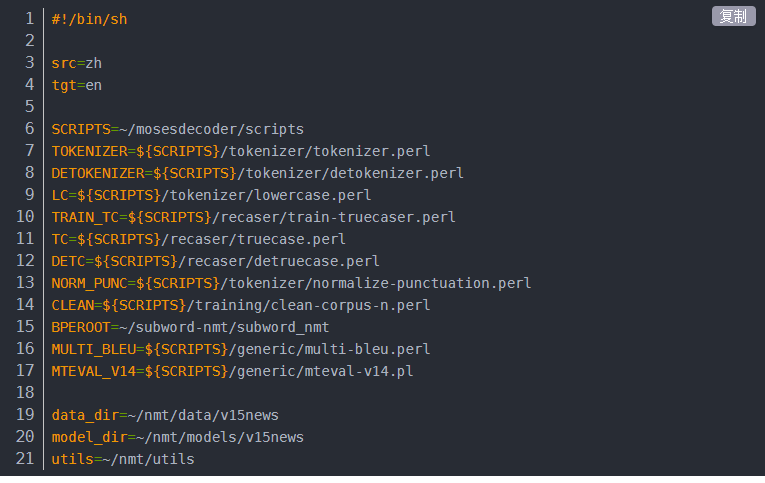




In [10]:
import sys
import os

def cut(fpath,new_data_dir,nsrc='zh',ntgt='en'):
    fp=open(fpath,encoding='utf-8')
    src_fp=open(os.path.join(new_data_dir,'raw.'+nsrc),'w',encoding='utf-8')
    tgt_fp=open(os.path.join(new_data_dir,'raw.'+ntgt),'w',encoding='utf-8')

    for line in fp.readlines():
        tgt_line,src_line=line.replace('\n','').split('\t')
        src_fp.write(src_line+'\n')
        tgt_fp.write(tgt_line+'\n')

    src_fp.close()
    tgt_fp.close()


cut('nmt/data/news-commentary-v15.en-zh.tsv','nmt/data/')

In [11]:
!head -n 5 nmt/data/raw.en
!head -n 5 nmt/data/raw.zh

1929 or 1989?
PARIS – As the economic crisis deepens and widens, the world has been searching for historical analogies to help us understand what has been happening.
At the start of the crisis, many people likened it to 1982 or 1973, which was reassuring, because both dates refer to classical cyclical downturns.
Today, the mood is much grimmer, with references to 1929 and 1931 beginning to abound, even if some governments continue to behave as if the crisis was more classical than exceptional.
The tendency is either excessive restraint (Europe) or a diffusion of the effort (the United States).
1929年还是1989年?
巴黎-随着经济危机不断加深和蔓延，整个世界一直在寻找历史上的类似事件希望有助于我们了解目前正在发生的情况。
一开始，很多人把这次危机比作1982年或1973年所发生的情况，这样得类比是令人宽心的，因为这两段时期意味着典型的周期性衰退。
如今人们的心情却是沉重多了，许多人开始把这次危机与1929年和1931年相比，即使一些国家政府的表现仍然似乎把视目前的情况为是典型的而看见的衰退。
目前的趋势是，要么是过度的克制（欧洲 ） ， 要么是努力的扩展（美国 ） 。


# 数据预处理
分以下几步进行

*     标点符号标准化
*     jieba中文分词
*     tokenize 英文单词与标点分开，转换连续空格，符号变为转义字符
*     truecase 转换大小写为适合学习的形式
*     将分词后结果细分为BPE子词
*     clean 对语料截取长度，最大长度到最小长度之间（1-256）
*     split 划分训练，验证，测试集


In [18]:
#标点符号的标准化

!perl mosesdecoder/scripts/tokenizer/normalize-punctuation.perl -l en < nmt/data/raw.en > nmt/data/norm.en
!perl mosesdecoder/scripts/tokenizer/normalize-punctuation.perl -l zh < nmt/data/raw.zh > nmt/data/norm.zh

In [19]:
#中文分词
!python -m jieba -d ' ' nmt/data/norm.zh > nmt/data/norm.seg.zh

Building prefix dict from the default dictionary ...
Dumping model to file cache /tmp/jieba.cache
Loading model cost 0.915 seconds.
Prefix dict has been built successfully.


In [20]:
!head -n 5 nmt/data/norm.seg.zh

1929 年 还是 1989 年 ?
巴黎 - 随着 经济危机 不断 加深 和 蔓延 ， 整个 世界 一直 在 寻找 历史 上 的 类似 事件 希望 有助于 我们 了解 目前 正在 发生 的 情况 。
一 开始 ， 很多 人 把 这次 危机 比作 1982 年 或 1973 年 所 发生 的 情况 ， 这样 得 类比 是 令人 宽心 的 ， 因为 这 两段 时期 意味着 典型 的 周期性 衰退 。
如今 人们 的 心情 却是 沉重 多 了 ， 许多 人 开始 把 这次 危机 与 1929 年 和 1931 年 相比 ， 即使 一些 国家 政府 的 表现 仍然 似乎 把视 目前 的 情况 为 是 典型 的 而 看见 的 衰退 。
目前 的 趋势 是 ， 要么 是 过度 的 克制 （ 欧洲   ）   ，   要么 是 努力 的 扩展 （ 美国   ）   。


In [22]:
#tokenize 分词，将符号替换为转义字符
!mosesdecoder/scripts/tokenizer/tokenizer.perl -l en <nmt/data/norm.en >nmt/data/norm.tok.en
!mosesdecoder/scripts/tokenizer/tokenizer.perl -l zh <nmt/data/norm.seg.zh >nmt/data/norm.tok.zh


Tokenizer Version 1.1
Language: en
Number of threads: 1
Tokenizer Version 1.1
Language: zh
Number of threads: 1


In [26]:
#转换大小写
!mosesdecoder/scripts/recaser/train-truecaser.perl --model nmt/model/truecase-model.en --corpus nmt/data/norm.tok.en
!mosesdecoder/scripts/recaser/truecase.perl --model nmt/model/truecase-model.en < nmt/data/norm.tok.en > nmt/data/norm.tok.true.en

In [ ]:
!ls 

In [36]:
#BPE划分子词
!python subword-nmt/subword_nmt/learn_joint_bpe_and_vocab.py --input nmt/data/norm.tok.true.en -s 32000 -o nmt/data/bpecode.en --write-vocabulary nmt/data/voc.en
!python subword-nmt/subword_nmt/apply_bpe.py -c nmt/data/bpecode.en --vocabulary nmt/data/voc.en <nmt/data/norm.tok.true.en >nmt/data/bpe.en

!python subword-nmt/subword_nmt/learn_joint_bpe_and_vocab.py --input nmt/data/norm.seg.zh -s 32000 -o nmt/data/bpecode.zh --write-vocabulary nmt/data/voc.zh
!python subword-nmt/subword_nmt/apply_bpe.py -c nmt/data/bpecode.zh --vocabulary nmt/data/voc.zh <nmt/data/norm.seg.zh >nmt/data/bpe.zh

100% 32000/32000 [00:52<00:00, 609.76it/s]
100% 32000/32000 [00:52<00:00, 605.52it/s]


In [37]:
!head -n 5 nmt/data/bpe.en
!head -n 5 nmt/data/bpe.zh

1929 or 1989 ?
Paris - As the economic crisis deepens and wid@@ ens , the world has been searching for historical analogies to help us understand what has been happening .
at the start of the crisis , many people likened it to 1982 or 1973 , which was reassuring , because both dates refer to classical cyclical downturns .
today , the mood is much gri@@ mmer , with references to 1929 and 1931 beginning to abound , even if some governments continue to behave as if the crisis was more classical than exceptional .
the tendency is either excessive restraint ( Europe ) or a diffusion of the effort ( the United States ) .
1929 年 还是 1989 年 ?
巴黎 - 随着 经济危机 不断 加深 和 蔓延 ， 整个 世界 一直 在 寻找 历史 上 的 类似 事件 希望 有助于 我们 了解 目前 正在 发生 的 情况 。
一 开始 ， 很多 人 把 这次 危机 比作 1982 年 或 1973 年 所 发生 的 情况 ， 这样 得 类比 是 令人 宽@@ 心 的 ， 因为 这 两@@ 段 时期 意味着 典型 的 周期性 衰退 。
如今 人们 的 心情 却是 沉重 多 了 ， 许多 人 开始 把 这次 危机 与 1929 年 和 1931 年 相比 ， 即使 一些 国家 政府 的 表现 仍然 似乎 把@@ 视 目前 的 情况 为 是 典型 的 而 看见 的 衰退 。
目前 的 趋势 是 ， 要么 是 过度 的 克制 （ 欧洲 ） ， 要么 是 努力 的 扩展 （ 美

In [38]:
#clean 过滤空白行和超过256长度的句子
!mosesdecoder/scripts/training/clean-corpus-n.perl nmt/data/bpe zh en nmt/data/clean 1 256

clean-corpus.perl: processing nmt/data/bpe.zh & .en to nmt/data/clean, cutoff 1-256, ratio 9
..........(100000)..........(200000)..........(300000)..
Input sentences: 320713  Output sentences:  312215


In [40]:
#split 划分为训练
import random 

def split(src_fpath,tgt_fpath,nsrc='zh',ntgt='en',ratio=(0.9,0.05,0.05),new_data_dir='nmt/data'):
  src_fp=open(src_fpath,'r',encoding='utf-8')
  tgt_fp=open(tgt_fpath,'r',encoding='utf-8')

  src_train,src_valid,src_test=open(os.path.join(new_data_dir,'train.'+nsrc),'w',encoding='utf-8'),open(os.path.join(new_data_dir,'valid.'+nsrc),'w',encoding='utf-8'),open(os.path.join(new_data_dir,'test.'+nsrc),'w',encoding='utf-8')
  tgt_train,tgt_valid,tgt_test=open(os.path.join(new_data_dir,'train.'+ntgt),'w',encoding='utf-8'),open(os.path.join(new_data_dir,'valid.'+ntgt),'w',encoding='utf-8'),open(os.path.join(new_data_dir,'test.'+ntgt),'w',encoding='utf-8')

  src,tgt=src_fp.readlines(),tgt_fp.readlines()

  for s,t in zip(src,tgt):
    rand=random.random()
    if 0<rand<=ratio[0]:
      src_train.write(s)
      tgt_train.write(t)
    elif ratio[0]<rand<=ratio[0]+ratio[1]:
      src_valid.write(s)
      tgt_valid.write(t)
    else:
      src_test.write(s)
      tgt_test.write(t)

  src_fp.close()
  tgt_fp.close()
  src_train.close()
  tgt_train.close()
  src_valid.close()
  tgt_valid.close()
  src_test.close()
  tgt_test.close()

split('nmt/data/clean.zh','nmt/data/clean.en',)


#fairseq训练过程
首先使用fairseq-preprocess命令生成词表和训练用二进制文件

In [46]:
!fairseq-preprocess --source-lang zh --target-lang en \
    --trainpref nmt/data/train --validpref nmt/data/valid --testpref nmt/data/test --destdir nmt/data/data-bin

2022-02-22 11:38:39 | INFO | fairseq.tasks.text_to_speech | Please install tensorboardX: pip install tensorboardX
2022-02-22 11:38:40 | INFO | fairseq_cli.preprocess | Namespace(align_suffix=None, alignfile=None, all_gather_list_size=16384, amp=False, amp_batch_retries=2, amp_init_scale=128, amp_scale_window=None, azureml_logging=False, bf16=False, bpe=None, cpu=False, criterion='cross_entropy', dataset_impl='mmap', destdir='nmt/data/data-bin', dict_only=False, empty_cache_freq=0, fp16=False, fp16_init_scale=128, fp16_no_flatten_grads=False, fp16_scale_tolerance=0.0, fp16_scale_window=None, joined_dictionary=False, log_file=None, log_format=None, log_interval=100, lr_scheduler='fixed', memory_efficient_bf16=False, memory_efficient_fp16=False, min_loss_scale=0.0001, model_parallel_size=1, no_progress_bar=False, nwordssrc=-1, nwordstgt=-1, on_cpu_convert_precision=False, only_source=False, optimizer=None, padding_factor=8, plasma_path='/tmp/plasma', profile=False, quantization_config_pat

In [48]:
#训练,为了提前结束，这里min-loss-scale 当loss降低到0.5就结束训练，默认值为0.0001，max-tokens 一般设为4000，这里设置为2048
!fairseq-train nmt/data/data-bin  --arch transformer \
                  --source-lang zh --target-lang en\
                  --optimizer adam --lr 0.001 --adam-betas '(0.9,0.98)' \
                  --lr-scheduler inverse_sqrt --max-tokens 2048 --dropout 0.3 \
                  --criterion label_smoothed_cross_entropy --label-smoothing 0.1 \
                  --min-loss-scale 0.5\
                  --keep-last-epochs 2 --num-workers 8\
                  --save-dir nmt/model/checkpoints

2022-02-22 11:51:08 | INFO | numexpr.utils | NumExpr defaulting to 2 threads.
2022-02-22 11:51:09 | INFO | fairseq.tasks.text_to_speech | Please install tensorboardX: pip install tensorboardX
2022-02-22 11:51:12 | INFO | fairseq_cli.train | {'_name': None, 'common': {'_name': None, 'no_progress_bar': False, 'log_interval': 100, 'log_format': None, 'log_file': None, 'tensorboard_logdir': None, 'wandb_project': None, 'azureml_logging': False, 'seed': 1, 'cpu': False, 'tpu': False, 'bf16': False, 'memory_efficient_bf16': False, 'fp16': False, 'memory_efficient_fp16': False, 'fp16_no_flatten_grads': False, 'fp16_init_scale': 128, 'fp16_scale_window': None, 'fp16_scale_tolerance': 0.0, 'on_cpu_convert_precision': False, 'min_loss_scale': 0.5, 'threshold_loss_scale': None, 'amp': False, 'amp_batch_retries': 2, 'amp_init_scale': 128, 'amp_scale_window': None, 'user_dir': None, 'empty_cache_freq': 0, 'all_gather_list_size': 16384, 'model_parallel_size': 1, 'quantization_config_path': None, 'pr

#解码
fairseq支持两种解码命令 generate和interactive 

*     generate使用二进制文件，符合自己做实验如WMT数据集上
*     interactive  用于文本文件，符合比赛常见


In [49]:
#用于保存所以结果文件
!mkdir nmt/result

In [50]:
#生成式解码
!fairseq-generate nmt/data/data-bin\
  --path nmt/model/checkpoints/checkpoint_best.pt \
  --batch-size 128 --beam 8 > nmt/result/bestbeam8.txt



2022-02-22 13:07:05 | INFO | fairseq.tasks.text_to_speech | Please install tensorboardX: pip install tensorboardX
2022-02-22 13:07:07 | INFO | fairseq_cli.generate | {'_name': None, 'common': {'_name': None, 'no_progress_bar': False, 'log_interval': 100, 'log_format': None, 'log_file': None, 'tensorboard_logdir': None, 'wandb_project': None, 'azureml_logging': False, 'seed': 1, 'cpu': False, 'tpu': False, 'bf16': False, 'memory_efficient_bf16': False, 'fp16': False, 'memory_efficient_fp16': False, 'fp16_no_flatten_grads': False, 'fp16_init_scale': 128, 'fp16_scale_window': None, 'fp16_scale_tolerance': 0.0, 'on_cpu_convert_precision': False, 'min_loss_scale': 0.0001, 'threshold_loss_scale': None, 'amp': False, 'amp_batch_retries': 2, 'amp_init_scale': 128, 'amp_scale_window': None, 'user_dir': None, 'empty_cache_freq': 0, 'all_gather_list_size': 16384, 'model_parallel_size': 1, 'quantization_config_path': None, 'profile': False, 'reset_logging': False, 'suppress_crashes': False, 'use_p

In [52]:
#交互式解码
!fairseq-interactive nmt/data/data-bin --input nmt/data/test.zh \
      --path nmt/model/checkpoints/checkpoint_best.pt \
      --batch-size 1 --beam 8 --remove-bpe >nmt/result/bestbeam8_act.txt

2022-02-22 13:17:57 | INFO | fairseq.tasks.text_to_speech | Please install tensorboardX: pip install tensorboardX
2022-02-22 13:18:00 | INFO | fairseq_cli.interactive | {'_name': None, 'common': {'_name': None, 'no_progress_bar': False, 'log_interval': 100, 'log_format': None, 'log_file': None, 'tensorboard_logdir': None, 'wandb_project': None, 'azureml_logging': False, 'seed': 1, 'cpu': False, 'tpu': False, 'bf16': False, 'memory_efficient_bf16': False, 'fp16': False, 'memory_efficient_fp16': False, 'fp16_no_flatten_grads': False, 'fp16_init_scale': 128, 'fp16_scale_window': None, 'fp16_scale_tolerance': 0.0, 'on_cpu_convert_precision': False, 'min_loss_scale': 0.0001, 'threshold_loss_scale': None, 'amp': False, 'amp_batch_retries': 2, 'amp_init_scale': 128, 'amp_scale_window': None, 'user_dir': None, 'empty_cache_freq': 0, 'all_gather_list_size': 16384, 'model_parallel_size': 1, 'quantization_config_path': None, 'profile': False, 'reset_logging': False, 'suppress_crashes': False, 'us

#后处理
*      将解码生成文件中译文与正确答案抽取出来
*      去除bpe符合
*      恢复大小写正常

In [53]:
#从解码文件中抽取
!grep ^H nmt/result/bestbeam8.txt |cut -f3 >nmt/result/predict.bpe.en
!grep ^T nmt/result/bestbeam8.txt |cut -f2 >nmt/result/answer.bpe.en

In [60]:
!head -n 30 nmt/result/bestbeam8.txt

S-716	北约 的 新 边界
T-716	NATO &apos;s New Frontier
H-716	-1.6583664417266846	new YORK - Europe is the world &apos;s largest country .
D-716	-1.6583664417266846	new YORK - Europe is the world &apos;s largest country .
P-716	-2.7592 -0.5841 -0.0321 -3.3731 -2.1757 -2.4677 -2.9088 -0.8209 -1.2908 -2.5991 -0.8637 -0.0251
S-13590	危机 会 发生 。
T-13590	crises occur .
H-13590	-1.9613300561904907	the question now is whether the crisis will be .
D-13590	-1.9613300561904907	the question now is whether the crisis will be .
P-13590	-1.8925 -3.6307 -2.3272 -1.0133 -0.7788 -0.9914 -2.4545 -2.4382 -2.0384 -3.9881 -0.0216
S-11532	可以 省钱 的 补贴
T-11532	subsidies that Save
H-11532	-1.9867991209030151	to be sure , the government will need to pay a high price .
D-11532	-1.9867991209030151	to be sure , the government will need to pay a high price .
P-11532	-5.3902 -2.0141 -0.4095 -0.0624 -2.2487 -2.9832 -2.7457 -1.8918 -0.2061 -2.6012 -3.9066 -3.0243 -1.1542 -1.1426 -0.0213
S-8019	天安门 事件 的 教训
T-8019	lessons from Tia

In [62]:
#去除bpe符合
!sed -r 's/(@@ )| (@@ ?$)//g' < nmt/result/predict.bpe.en  > nmt/result/predict.tok.true.en
!sed -r 's/(@@ )| (@@ ?$)//g' < nmt/result/answer.bpe.en  > nmt/result/answer.tok.true.en


In [63]:
#恢复大小写正常

!mosesdecoder/scripts/recaser/detruecase.perl <nmt/result/predict.tok.true.en >nmt/result/predict.tok.en
!mosesdecoder/scripts/recaser/detruecase.perl <nmt/result/answer.tok.true.en >nmt/result/answer.tok.en

#评估

翻译评估主要使用bleu值

*     multi-bleu
*     sacrebleu

In [64]:
#mutli-bleu 在detokenize前进行评价

!mosesdecoder/scripts/generic/multi-bleu.perl -lc nmt/result/answer.tok.en <nmt/result/predict.tok.en


BLEU = 1.69, 29.7/4.1/1.0/0.3 (BP=0.666, ratio=0.711, hyp_len=281454, ref_len=395734)
It is not advisable to publish scores from multi-bleu.perl.  The scores depend on your tokenizer, which is unlikely to be reproducible from your paper or consistent across research groups.  Instead you should detokenize then use mteval-v14.pl, which has a standard tokenization.  Scores from multi-bleu.perl can still be used for internal purposes when you have a consistent tokenizer.


In [ ]:
#sacrebleu 在detokenize后进行评价,需要安装对应库

#!sacrebleu ref.detok.txt -i output.detok.txt -m bleu -b w 4

#cat output.detok.txt | sacrebleu ref.detok.txt -m bleu -b -w 4

In [65]:
#使用detokenizer 预测得到纯文本

!mosesdecoder/scripts/tokenizer/detokenizer.perl -l en < nmt/result/predict.tok.en >nmt/result/predict.en

Detokenizer Version $Revision: 4134 $
Language: en


In [66]:
!head -n 30 nmt/result/predict.en

New YORK - Europe is the world's largest country.
The question now is whether the crisis will be.
To be sure, the government will need to pay a high price.
This is the case of the history of the twentieth century.
Israel is no longer a Palestinian state.
The World Economic Forum of Economic Forum
The same is true of the "soft power."
Egypt is the first country in the country.
A few weeks later, the police were killed.
The Greek economy is the first option.
The first of the twentieth century of the twentieth century was the first time of the twentieth century.
The World Health Organization, for example, is the most part of the world.
The World Bank is the world's largest economy.
In the Arab world, the Arab Spring of the Arab Spring has become a major threat to democracy.
This is the case of the South China Sea.
The first option is to reduce carbon emissions.
The US is the world's largest ally.
Europe is the world.
That is not the case.
New YORK - In the last two years, China has been t